In [2]:
%load_ext autoreload
%autoreload 2

# Imports

In [17]:
import pandas as pd
from pandas.io.formats.style import Styler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline

from ipywidgets import interact, HBox, VBox, HTML, Dropdown, Layout, FloatSlider
from IPython.display import display, clear_output

import os
import sys
import math

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from umap import UMAP

from cycler import cycler
from colorama import Style, Fore

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

# Font & Plot Styling

In [3]:
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

palette = ['#3c3744', '#048BA8', '#EE6352', '#E1BB80', '#78BC61']
grey_palette = ['#8e8e93', '#636366', '#48484a', '#3a3a3c', '#2c2c2e', '#1c1c27']
bg_color = '#F6F5F5'
white_color = '#d1d1d6'

custom_params = {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.left': False,
    'grid.alpha':0.2,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'ytick.labelsize': 'medium',
    'xtick.labelsize': 'medium',
    'legend.fontsize': 'large',
    'lines.linewidth': 1,
    'axes.prop_cycle': cycler('color',palette),
    'figure.facecolor': bg_color,
    'figure.edgecolor': bg_color,
    'axes.facecolor': bg_color,
    'text.color':grey_palette[1],
    'axes.labelcolor':grey_palette[1],
    'axes.edgecolor':grey_palette[1],
    'xtick.color':grey_palette[1],
    'ytick.color':grey_palette[1],
    'figure.dpi':150,
}
sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params)

# Loading Data

In [4]:
orig = pd.read_csv(os.path.join(CFG.RAW_DATA, 'Pulsar.csv'))
train = pd.read_csv(os.path.join(CFG.RAW_DATA, 'train.csv')).drop(columns='id')
test = pd.read_csv(os.path.join(CFG.RAW_DATA, 'test.csv')).drop(columns='id')

train.name = 'Train'
test.name = 'Test'
orig.name = 'Original'

# Helper Functions

In [5]:
def magnify(is_test: bool = False):
        base_color = '#457ea5'
        if is_test:
                highlight_target_row = []
        else:
                highlight_target_row = [
                    dict(
                        selector='tr:last-child',
                        props=[('background-color', f'{base_color}20')],
                    )
                ]

        return [dict(selector="th",
                     props=[("font-size", "11pt"),
                            ('background-color', f'{base_color}'),
                            ('color', 'white'),
                            ('font-weight', 'bold'),
                            ('border-bottom', '0.1px solid white'),
                            ('border-left', '0.1px solid white'),
                            ('text-align', 'right')]),

                dict(selector='th.blank.level0', 
                    props=[('font-weight', 'bold'),
                           ('border-left', '1.7px solid white'),
                           ('background-color', 'white')]),

                dict(selector="td",
                     props=[('padding', "0.5em 1em"),
                            ('text-align', 'right')]),

                dict(selector="th:hover",
                     props=[("font-size", "14pt")]),

                dict(selector="tr:hover td:hover",
                     props=[('max-width', '250px'),
                            ('font-size', '14pt'),
                            ('color', f'{base_color}'),
                            ('font-weight', 'bold'),
                            ('background-color', 'white'),
                            ('border', f'1px dashed {base_color}')]),

                 dict(selector="caption",
                      props=[(('caption-side', 'bottom'))])] + highlight_target_row

def stylize_min_max_count(pivot_table):
    """
    Wraps the min_max_count pivot_table into the Styler.

        Args:
            df: |min_train| max_train |min_test |max_test |top10_counts_train |top_10_counts_train|
    """
    s = pivot_table
    # A formatting dictionary for controlling each column precision (.000 <-). 
    di_frmt = {(i if i.startswith('m') else i):
              ('{:.3f}' if i.startswith('m') else '{:}') for i in s.columns}

    s = s.style.set_table_styles(magnify(True))\
        .format(di_frmt)\
        .set_caption("The train and test datasets min, max, top10 values side by side (hover to magnify).")
    return s

def stylize_describe(df: pd.DataFrame, dataset_name: str = 'train', is_test: bool = False) -> Styler:
    """
    Applies .describe() method to the df and wraps it into the Styler.
                     
        Returns:
            s: the dataframe wrapped into Styler.
    """
    s = df.describe().T
    # A formatting dictionary for controlling each column precision (.000 <-). 
    di_frmt = {(i if i == 'count' else i):
              ('{:.0f}' if i == 'count' else '{:.3f}') for i in s.columns}
    
    s = s.style.set_table_styles(magnify(is_test))\
        .format(di_frmt)\
        .set_caption(f"The {dataset_name} dataset descriptive statistics (hover to magnify).")
    return s

def stylize_simple(df: pd.DataFrame, caption: str) -> Styler:
    """
    Wraps the min_max_count pivot_table into the Styler.
    """
    s = df
    s = s.style.set_table_styles(magnify(True)).set_caption(f"{caption}")
    return s

# Basic Information
## Shape

In [13]:
print(f'{gld}[INFO] Shapes:'
      f'{gld}\n[+] origin ->  {red}{orig.shape}'
      f'{gld}\n[+] train  -> {red}{train.shape}'
      f'{gld}\n[+] test   ->  {red}{test.shape}\n')

print(f'{gld}[INFO] Any missing values:'
      f'{gld}\n[+] orig -> {red}{orig.isna().any().any()}'
      f'{gld}\n[+] train  -> {red}{train.isna().any().any()}'
      f'{gld}\n[+] test   -> {red}{test.isna().any().any()}')

[INFO] Shapes:
[+] origin ->  (17898, 9)
[+] train  -> (117564, 9)
[+] test   ->  (78377, 8)

[INFO] Any missing values:
[+] orig -> False
[+] train  -> False
[+] test   -> False


## Statistics

In [14]:
display(stylize_simple(train.head(4), 'The train dataset 3 top rows (hover to magnify).'))
display(stylize_describe(train))
display(stylize_describe(test, 'test', is_test=True))

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0


,count,mean,std,min,25%,50%,75%,max
Mean_Integrated,117564,111.248,24.906,6.055,104.547,116.664,126.297,189.367
SD,117564,46.714,6.103,24.783,43.443,47.479,50.863,93.603
EK,117564,0.503,1.127,-1.731,0.050,0.186,0.396,7.880
Skewness,117564,1.886,6.515,-1.792,-0.189,0.092,0.692,65.386
Mean_DMSNR_Curve,117564,11.963,26.720,0.213,2.090,2.809,4.123,217.371
SD_DMSNR_Curve,117564,26.191,20.042,7.370,14.955,18.165,24.732,109.891
EK_DMSNR_Curve,117564,8.037,3.841,-2.598,6.743,8.443,10.003,34.540
Skewness_DMSNR_Curve,117564,93.881,79.962,-1.977,49.409,83.421,122.093,1191.001
Class,117564,0.093,0.291,0.000,0.000,0.000,0.000,1.000


,count,mean,std,min,25%,50%,75%,max
Mean_Integrated,78377,111.329,24.682,5.812,104.586,116.555,126.195,192.617
SD,78377,46.730,6.088,24.772,43.502,47.466,50.854,91.809
EK,78377,0.495,1.111,-1.788,0.050,0.185,0.395,8.070
Skewness,78377,1.834,6.401,-1.792,-0.190,0.091,0.692,64.117
Mean_DMSNR_Curve,78377,11.857,26.610,0.213,2.089,2.804,4.099,223.392
SD_DMSNR_Curve,78377,26.075,19.930,7.449,14.954,18.165,24.548,110.545
EK_DMSNR_Curve,78377,8.048,3.826,-2.557,6.756,8.444,9.973,31.472
Skewness_DMSNR_Curve,78377,94.034,79.906,-1.977,49.704,83.323,122.093,1072.793


# Min Max Counts

In [15]:
cm = sns.light_palette('#457ea5', as_cmap=True)

counts_tr = pd.Series({ft: [train[ft].value_counts().round(3).iloc[:5].to_dict()] for ft in train.columns}, name='top_5_counts_train')
counts_te = pd.Series({ft: [test[ft].value_counts().round(3).iloc[:5].to_dict()] for ft in test.columns}, name='top_5_counts_test')
nunique_tr = train.nunique().rename('nunique_train')
nunique_te = test.nunique().rename('nunique_test')
nunique_te['Class'] = 0

min_max = train.describe().T[['min', 'max']].add_suffix('_train').join(test.describe().T[['min', 'max']].add_suffix('_test'))
stats_pivot = pd.concat([min_max, nunique_tr, nunique_te, counts_tr, counts_te], axis=1)
stylize_min_max_count(stats_pivot).background_gradient(cm, subset=['min_test', 'min_train', 'max_train', 'max_test'])

,min_train,max_train,min_test,max_test,nunique_train,nunique_test,top_5_counts_train,top_5_counts_test
Mean_Integrated,6.055,189.367,5.812,192.617,11065,10063,"[{106.7109375: 127, 120.828125: 121, 123.828125: 113, 119.3046875: 111, 114.8125: 103}]","[{106.7109375: 93, 120.828125: 79, 114.8359375: 75, 123.5703125: 75, 123.828125: 74}]"
SD,24.783,93.603,24.772,91.809,49262,37058,"[{51.82915896: 73, 45.82762157: 59, 54.94868878: 57, 44.95531636: 54, 46.93619963: 53}]","[{51.82915896: 44, 48.91219013: 37, 46.93619963: 36, 54.94868878: 34, 45.82762157: 34}]"
EK,-1.731,7.880,-1.788,8.070,37132,28760,"[{0.527957554: 80, 0.262599764: 68, -0.049364179: 67, 0.034810744: 61, 0.339964064: 57}]","[{0.527957554: 50, 0.034810744: 44, 0.179841758: 43, 0.078459969: 39, 4.838103704: 39}]"
Skewness,-1.792,65.386,-1.792,64.117,41366,31604,"[{-0.374934811: 83, 0.099693988: 59, -0.07976327: 59, 0.039792179: 58, -0.253865826: 50}]","[{-0.07976327: 46, -0.259967627: 45, -0.171750769: 40, 0.764473291: 39, 0.039792179: 37}]"
Mean_DMSNR_Curve,0.213,217.371,0.213,223.392,12474,10851,"[{2.294314381: 225, 2.33277592: 224, 2.970735786: 223, 1.940635452: 220, 2.52090301: 206}]","[{2.33277592: 152, 2.970735786: 149, 1.940635452: 146, 2.943143813: 138, 2.52090301: 134}]"
SD_DMSNR_Curve,7.370,109.891,7.449,110.545,48050,36211,"[{16.76626465: 65, 14.83555934: 63, 13.82601301: 57, 17.89844422: 56, 14.72370745: 50}]","[{16.76626465: 52, 14.83555934: 50, 18.81215941: 39, 13.97951052: 37, 13.82601301: 36}]"
EK_DMSNR_Curve,-2.598,34.540,-2.557,31.472,42870,32807,"[{8.96401612: 73, 8.43257251: 64, 10.63844438: 61, 8.89029666: 59, 8.858354116: 59}]","[{8.43257251: 54, 8.96401612: 51, 10.83564068: 44, 8.979295493: 42, 8.099255716: 41}]"
Skewness_DMSNR_Curve,-1.977,1191.001,-1.977,1072.793,50648,37924,"[{-1.914087857: 85, 72.82662621: 54, 81.8654112: 49, 77.86910097: 44, -1.928211959: 43}]","[{-1.914087857: 67, -1.928211959: 35, 81.8654112: 35, 77.86910097: 31, -0.92402117: 31}]"
Class,0.000,1.000,nan,nan,2,0,"[{0: 106597, 1: 10967}]",nan


# Distributions

## Features

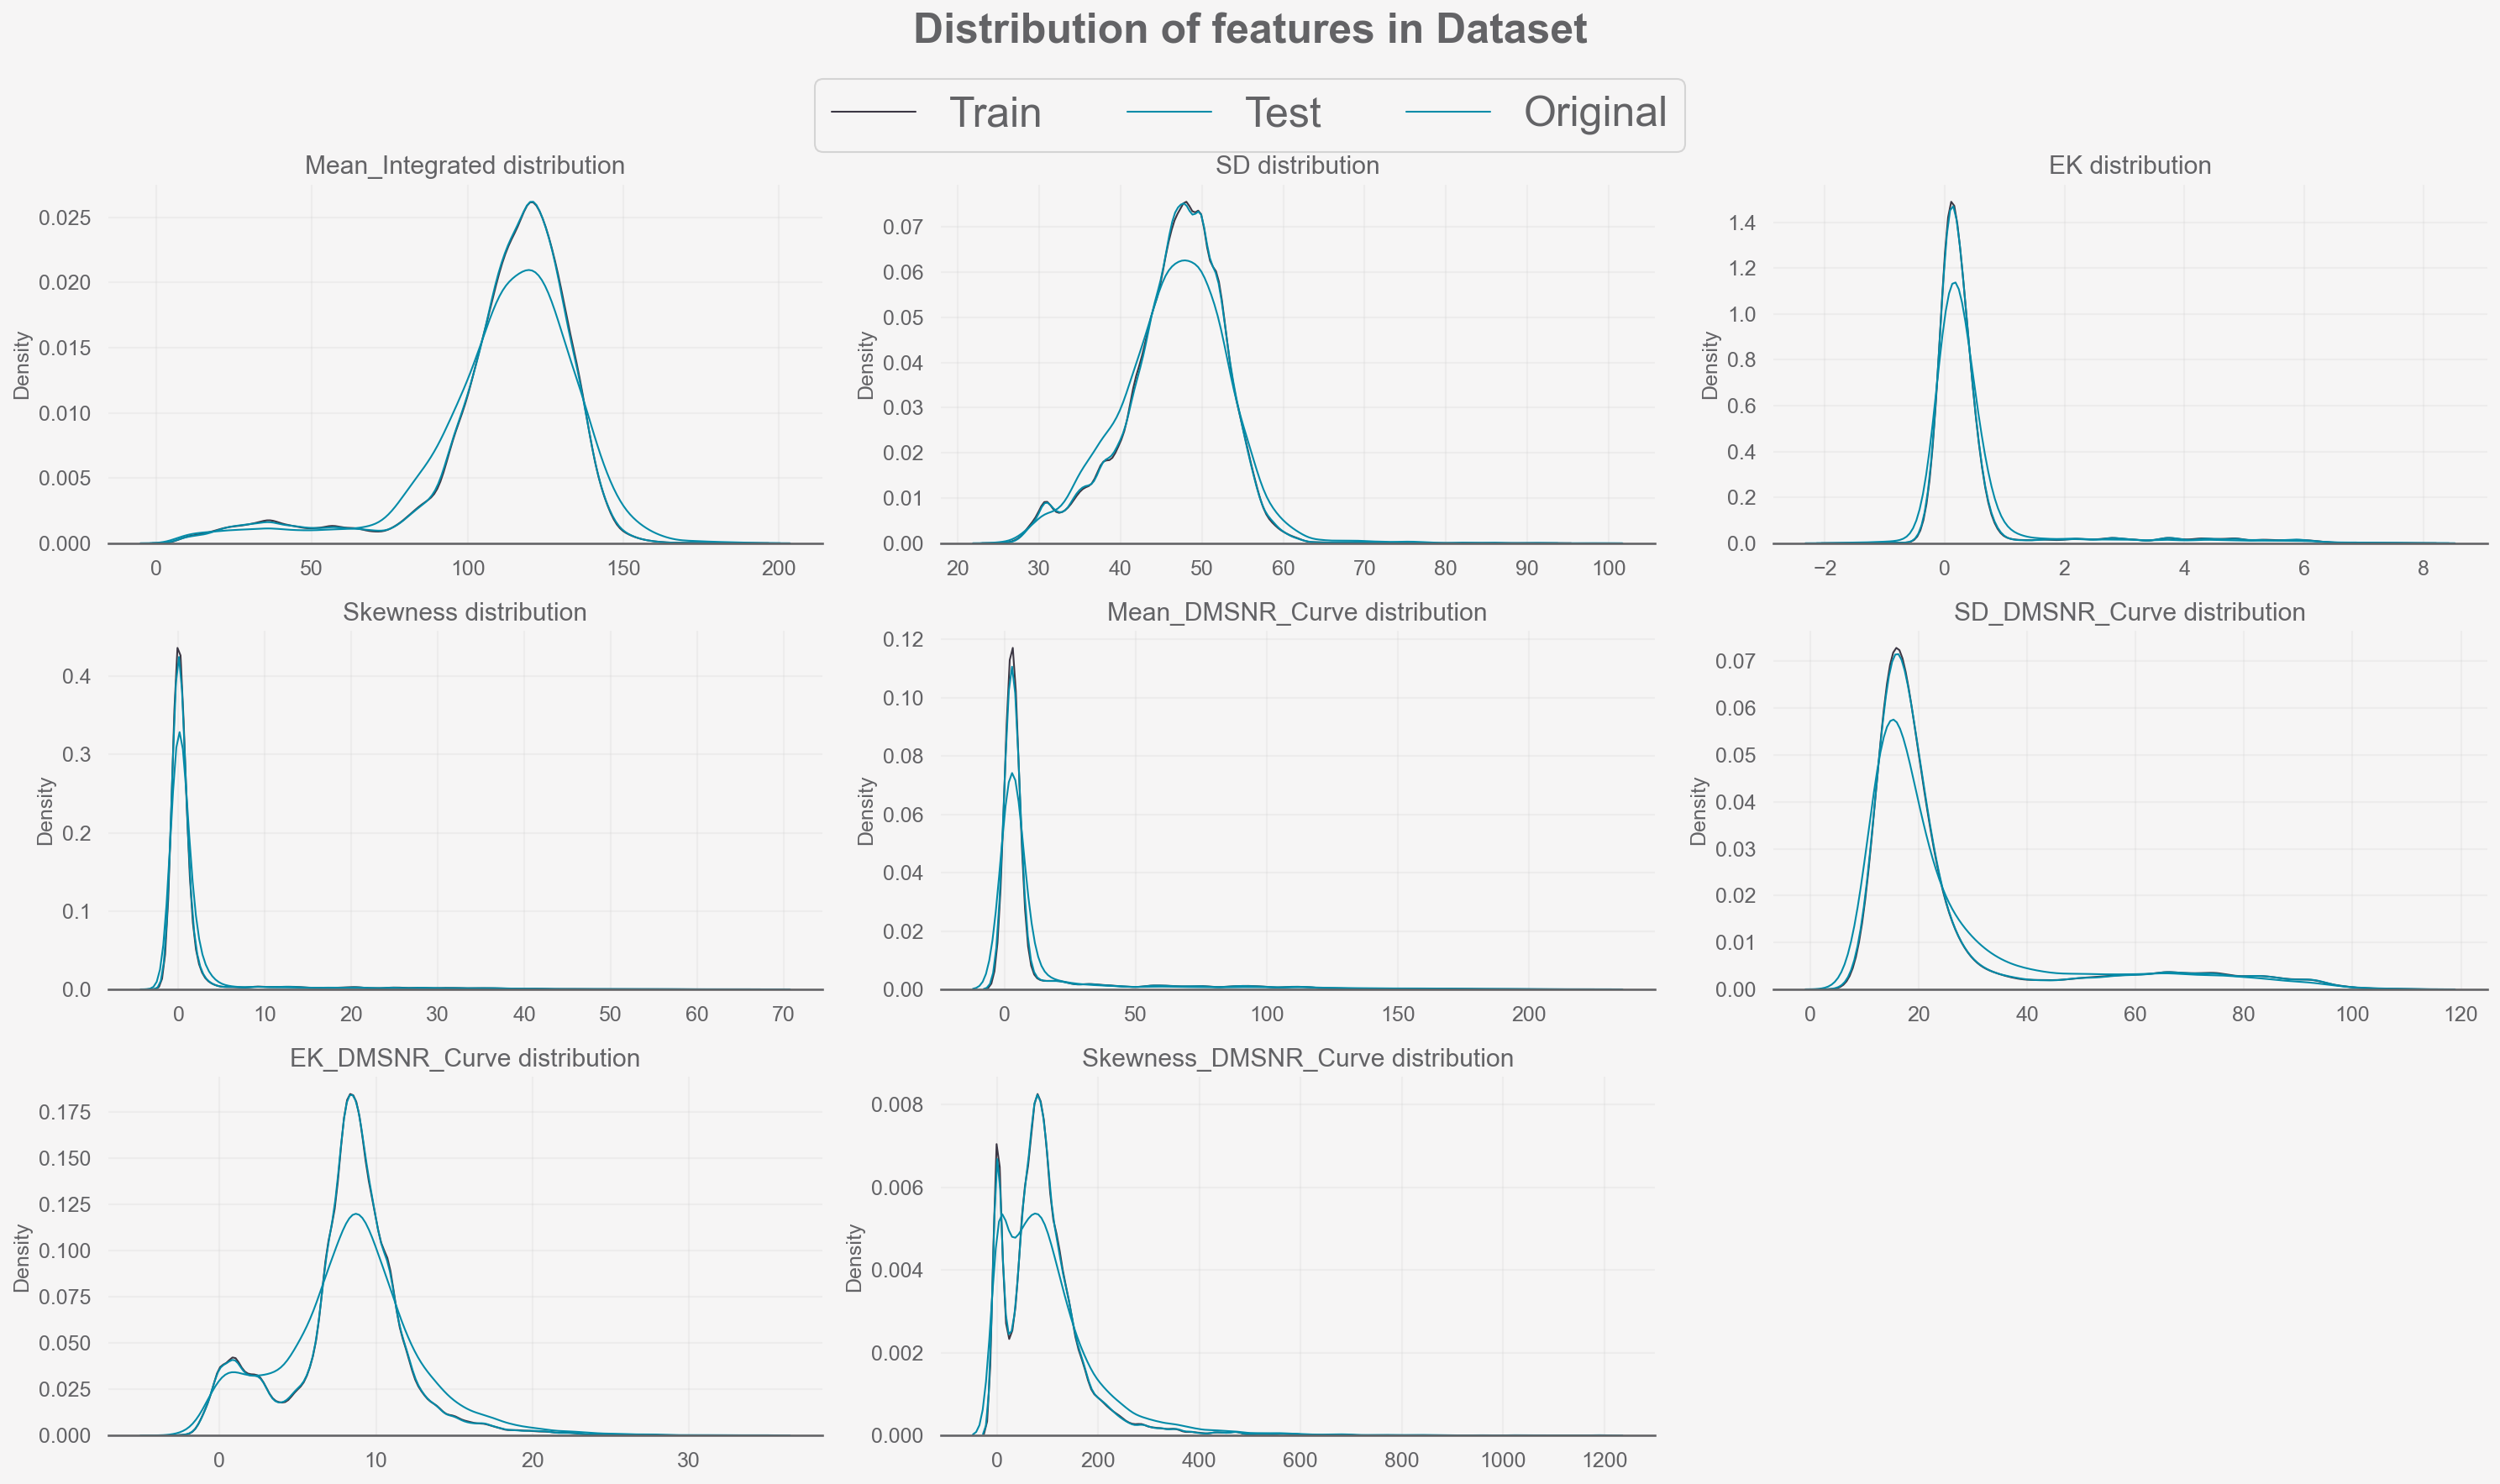

In [63]:
features = test.columns
ncols = 3
nrows = math.ceil(len(features) / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
axes = axes.flatten()

for i, col in enumerate(features):
    plot_axes = [axes[i]]
    sns.kdeplot(train[col], label='Train', ax=axes[i], color=palette[0])
    sns.kdeplot(test[col], label='Test', ax=axes[i], color=palette[1])
    sns.kdeplot(orig[col], label='Original', ax=axes[i], color=palette[-4])

    axes[i].set_title(f'{col} distribution')
    axes[i].set_xlabel('')

    handles = []
    labels = []
    for ax in plot_axes:
        handles += ax.get_legend_handles_labels()[0]
        labels += ax.get_legend_handles_labels()[1]
        ax.legend().remove()

for i in range(i+1, len(axes)):
    axes[i].axis('off')

fig.suptitle('Distribution of features in Dataset\n\n', fontsize=24, ha='center', fontweight='bold')
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=24, bbox_to_anchor=(0.5, 0.95))
plt.tight_layout()
plt.savefig('../data/images/features_distribution.png')
plt.show()

- Train and test are nearly identical but the original data has a different kde curve
- We will have to further invsetigate if it is too different to use with the train data

## Features vs. Class

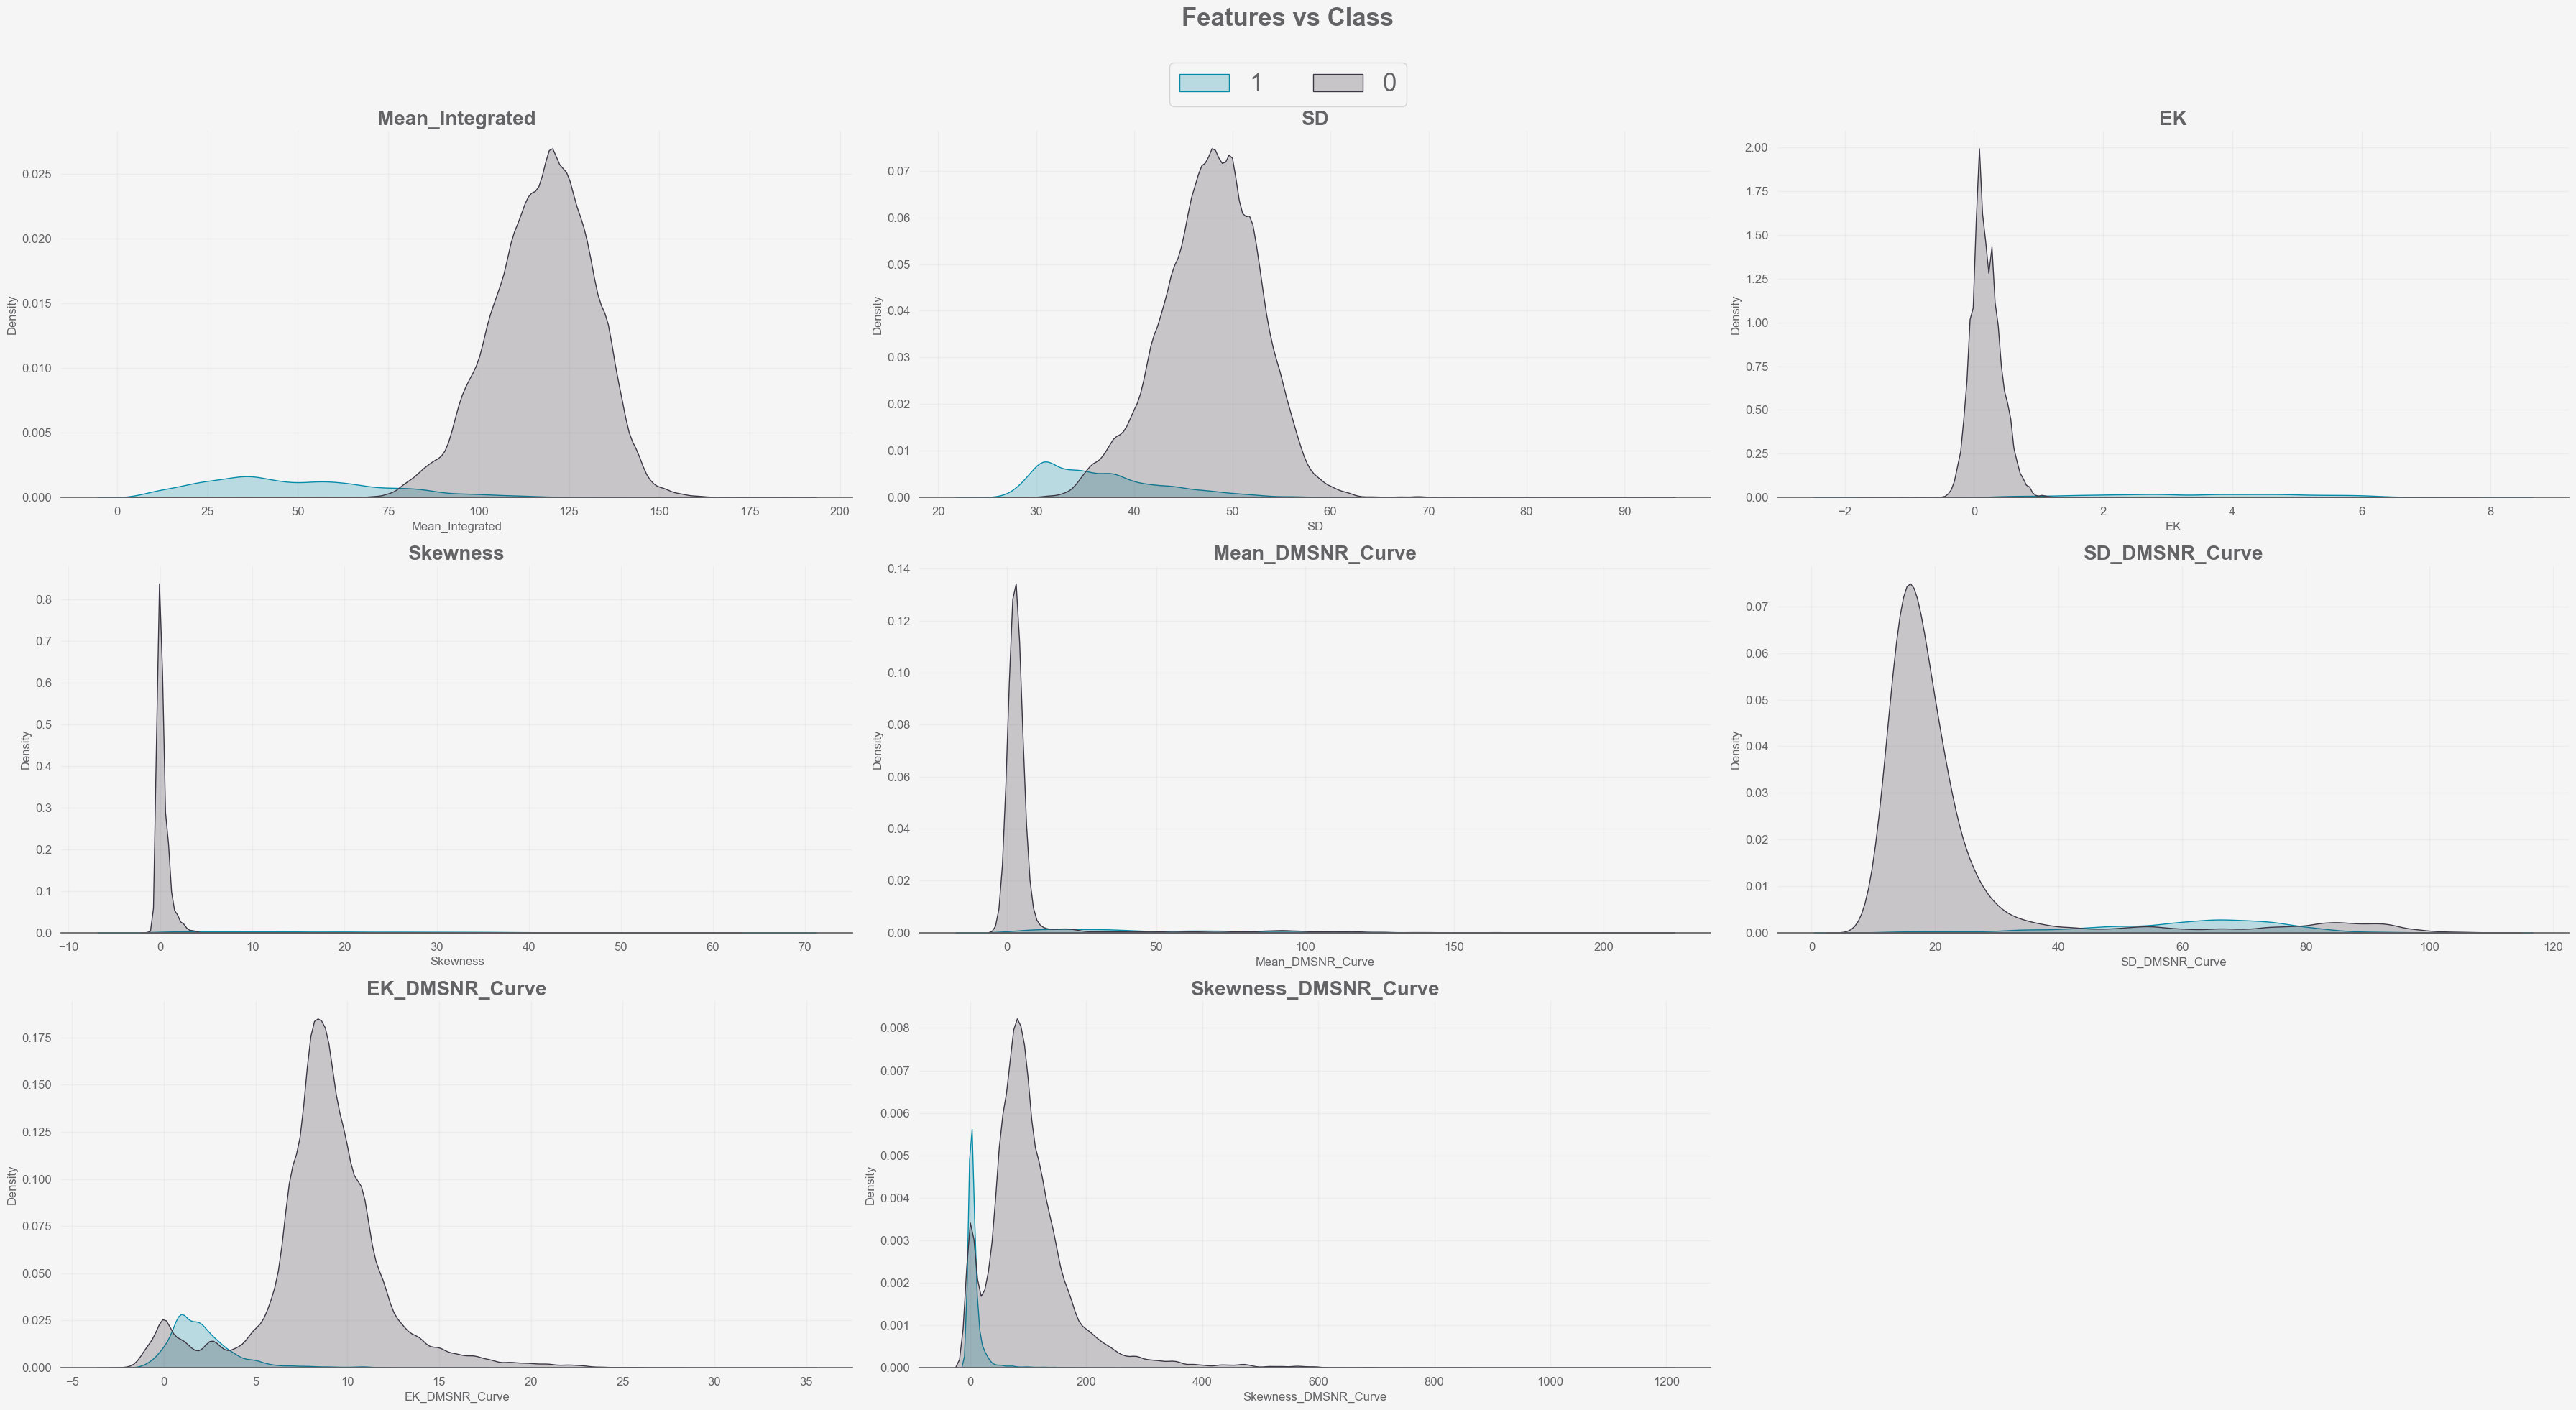

In [64]:
fig = plt.figure(figsize=(6*6, 20), dpi=100)

for idx, col in enumerate(features):
    ax = plt.subplot(3, 3, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=palette[:2], legend=False
    )
            
    ax.set_title(f'{col}', loc='center', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Class\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.95), fontsize=25, ncol=3)
plt.tight_layout()
plt.savefig('../data/images/feature_vs_class_dist.png')
plt.show()

- The distribution of the positive class is either very dense, or very flat
- The flat instances differ quite a bit from the negative class, I wouldn't be surprised to see a strong correlation between those features and class
- The long tails can be cleaned up with a log transformation

# Class Imbalance

In [65]:
@interact(df=[('Train'), ('Original')])
def plot_count(df: str) -> None:
    """
    Draws the pie and count plots for categorical variables.
    """
    df = train if df == 'Train' else orig
    title_name = df.name
    
    f, ax = plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(wspace=0)

    s1 = df['Class'].value_counts()
    N = len(s1)

    outer_sizes = s1
    inner_sizes = s1/N

    outer_colors = [palette[0], palette[0], '#ff781f', '#ff9752', '#ff9752']
    inner_colors = [palette[1], palette[1], '#ffa66b']

    ax[0].pie(
        outer_sizes,colors=outer_colors, 
        labels=s1.index.tolist(), 
        startangle=90,frame=True, radius=1.3, 
        explode=([0.05]*(N-1) + [.3]),
        wedgeprops={ 'linewidth' : 1, 'edgecolor' : 'white'}, 
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    textprops = {
        'size':13, 
        'weight': 'bold', 
        'color':'white'
    }

    ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=90,
        autopct='%1.f%%',explode=([.1]*(N-1) + [.3]),
        pctdistance=0.8, textprops=textprops
    )

    center_circle = plt.Circle((0,0), .68, color='black', 
                               fc='white', linewidth=0)
    ax[0].add_artist(center_circle)

    x = s1
    y = [0, 1]
    sns.barplot(
        x=x, y=y, ax=ax[1],
        palette=palette[:2], orient='horizontal'
    )

    ax[1].tick_params(
        axis='x',         
        which='both',      
        bottom=False,      
        labelbottom=False
    )

    for i, v in enumerate(s1):
        ax[1].text(v, i+0.1, str(v), color='black', 
                     fontweight='bold', fontsize=12)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel('Class', fontweight="bold", color='black')
    ax[1].set_ylabel('count', fontweight="bold", color='black')

    f.suptitle(f'{title_name} Dataset', fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../data/plot_count_{title_name}.png')
    plt.show()

interactive(children=(Dropdown(description='df', options=('Train', 'Original'), value='Train'), Output()), _do…

- Imbalanced classes, we will need to stratify the class when splitting for cross validation

# Correlations

In [27]:
@interact(df=['train', 'orig', 'test'])
def plot_heatmap(df: str):
    if df == 'train':
        df = train
    elif df == 'orig':
        df = orig
    else:
        df = test
    name = df.name
    corr = df.corr()
    plt.figure(figsize=(10, 5))
    mask = np.triu(np.ones_like(corr))
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap=['#D8E3E2', '#90A6B1', '#037d97'], annot=True)
    plt.title(f'{name} Dataset Correlation', fontsize=20, fontweight='bold')
    plt.savefig(f'../data/plot_heatmap_{name} Correlation.png')
    plt.show()

interactive(children=(Dropdown(description='df', options=('train', 'orig', 'test'), value='train'), Output()),…

- Lots of strong correlations
- Good chance to try filter techniques after interactions eg. polynomial

# 3D Visualization

In [66]:
style = {'description_width': 'initial'}

html = "<h1 style='font-size:30px'> 3D Visualization </h1>"
lbl = HTML(value= html)

dd_df = Dropdown(
    description='Select a Dataframe',
    options=['Train','Original'],
    value='Train',
    style=style,
    layout=Layout(width='auto')
)
dd_scaler = Dropdown(
    description='Select a Scaler',
    options=['standard','robust'],
    value='standard',
    style=style,
    layout=Layout(width='auto')
)
dd_dimred = Dropdown(
    description='Dimensionality Reduction',
    options=['PCA','TSNE', 'UMAP'],
    value='PCA',
    style=style,
    layout=Layout(width='auto')
)
sl_frac = FloatSlider(
    description='Fraction to Sample',
    min=0.01,
    max=1.0,
    step=0.01,
    value=0.01,
    continuous_update=False,
    style=style,
    layout=Layout(width='auto')
)

container1 = VBox([lbl, dd_df, dd_scaler, dd_dimred, sl_frac], layout=Layout(width='40%', padding=('50px 50px 50px 50px')))

def process_df(df_name, scaler, dimred, frac):
    df_dict = {'Train': train, 'Original': orig}
    reduc_dict = {'PCA': PCA(n_components=3), 'TSNE': TSNE(n_components=3), 'UMAP': UMAP(n_components=3)}
    scaler_dict = {'standard': StandardScaler(), 'robust': RobustScaler()}

    df = df_dict[df_name].copy()
    
    scaler = scaler_dict[scaler]
    scaled = pd.DataFrame(scaler.fit_transform(df.drop(columns=['Class'])), columns=df.drop(columns=['Class']).columns)
    scaled['Class'] = df['Class']

    scaled = scaled.groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=CFG.SEED))

    reduction = reduc_dict[dimred]
    projections = reduction.fit_transform(scaled.drop(columns=['Class']))
    projections = np.concatenate((projections, scaled['Class'].values.reshape((-1, 1))), axis=1)
    projections = pd.DataFrame(projections, columns=[0, 1, 2, 'Class'])
    projections['Class'] = projections['Class'].replace({0.0: palette[1], 1.0: palette[3]})

    return projections

sampled = process_df('Train', 'standard', 'PCA', 0.01)
trace = go.Scatter3d(
    x=sampled[0],
    y=sampled[1],
    z=sampled[2],
    mode='markers',
    marker=dict(
        size=3,
        color=sampled['Class'],
        opacity=0.7,
    ))
g = go.FigureWidget(
    data=[trace],
    layout=go.Layout(
        margin=dict(l=0, r=0, b=0, t=0),
        height=400,
        width=400)
)

container2 = VBox([g], layout=Layout(align_items='flex-end'))

def response(change):
    new_df = process_df(dd_df.value, dd_scaler.value, dd_dimred.value, sl_frac.value)
    with g.batch_update():
        g.data[0].x, g.data[0].y, g.data[0].z = new_df[0], new_df[1], new_df[2]
        g.data[0].marker.color = new_df['Class']

dd_df.observe(response, names='value')
dd_scaler.observe(response, names='value')
dd_dimred.observe(response, names='value')
sl_frac.observe(response, names='value')

container = HBox([container1, container2])
container

- The classes are quite nicely seperated
- This should make it fairly easy too get a decently performing model, but also much mor edifficult to make a great one
- This is due to the the few data points mingled in with the other class